In [57]:
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [58]:
hoja_df = pd.read_excel("./CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gasolina superior"]]


In [59]:
train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data


,Fecha,Gasolina superior,Año,Mes
0,2000-01-01,308156.82,2000,1
1,2000-02-01,307766.31,2000,2
2,2000-03-01,331910.29,2000,3
3,2000-04-01,315648.08,2000,4
4,2000-05-01,319667.97,2000,5
...,...,...,...,...
271,2022-08-01,581844.42,2022,8
272,2022-09-01,570632.20,2022,9
273,2022-10-01,573943.48,2022,10
274,2022-11-01,572163.23,2022,11


In [61]:
hoja_df_2025 = pd.read_excel("./VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gasolina superior"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)

# COnsumo de Gasolina

In [6]:
train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

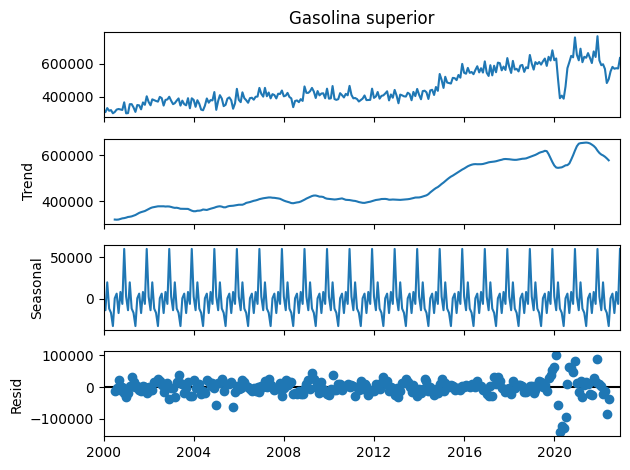

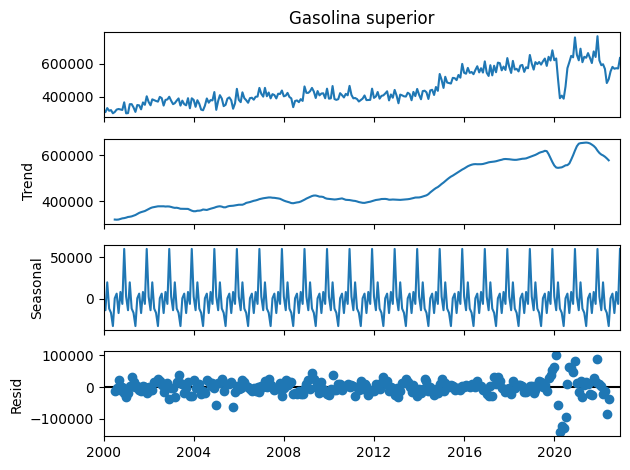

In [7]:
descomposicion = seasonal_decompose(train_data["Gasolina superior"])
descomposicion.plot()

In [9]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gasolina superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.268840
p-value                        0.643305
# de retardos usados          12.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


In [10]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gasolina superior"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -5.787650e+00
p-value                      4.956215e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.630000e+02
Critical Value (1%)         -3.455461e+00
Critical Value (5%)         -2.872593e+00
Critical Value (10%)        -2.572660e+00
dtype: float64


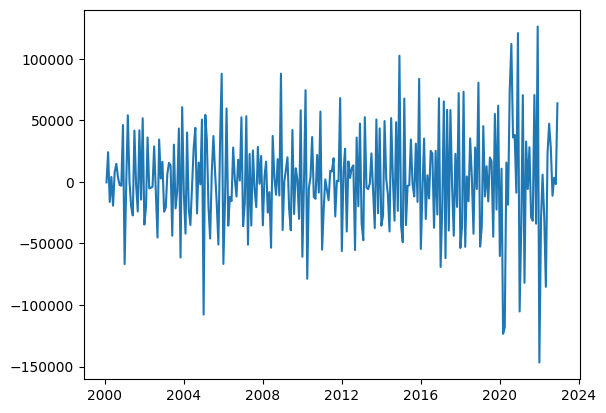

In [12]:
plt.plot(ts_air_pas_diff)


In [27]:
df = ts_air_pas_diff.to_frame()  # nombre por defecto será el nombre de la serie
print(df.columns)  # debería dar ['Gasolina superior'] o similar


Index(['Gasolina superior'], dtype='object')


In [29]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(df[["Gasolina superior"]])
ts_air_pas_scaled[1:7]

array([[ 0.55337278],
       [-0.4208209 ],
       [ 0.06818075],
       [-0.49455076],
       [ 0.16313417],
       [ 0.32582129]])

In [30]:
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

56

In [31]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [32]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

55

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

modelo1 = Sequential()
lote = 1
unidades = 1
paso = 1
caracteristicas = 1  # univariada

modelo1.add(Input(batch_shape=(lote, paso, caracteristicas)))
modelo1.add(LSTM(units=unidades, stateful=True))
modelo1.add(Dense(1))

modelo1.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (1, 1)                 │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [50]:
epocas = 95
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5374 - val_loss: 0.9701
Epoch 2/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5245 - val_loss: 0.9429
Epoch 3/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5110 - val_loss: 0.9143
Epoch 4/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4969 - val_loss: 0.8849
Epoch 5/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4826 - val_loss: 0.8556
Epoch 6/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4684 - val_loss: 0.8268
Epoch 7/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4547 - val_loss: 0.7994
Epoch 8/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4418 - val_loss: 0.7738
Epoch 9/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4300 - val_loss: 0.7504
Epoch 10/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4196 - val_loss: 0.7295
Epoch 11/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4106 - val_loss: 0.7111
Epoch 12/95
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

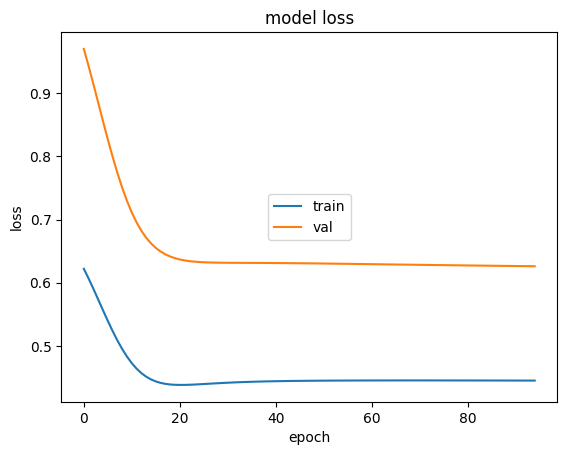

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [52]:
modelo1.evaluate(x_train, y_train, batch_size=1)
modelo1.evaluate(x_val, y_val, batch_size=1)
modelo1.evaluate(x_test, y_test, batch_size=1)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3934
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5945
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4224


2.1165614128112793

In [54]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df[["Gasolina superior"]].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df[["Gasolina superior"]].values , n=entrenamiento+val_prueba)


In [55]:
df_val = pd.DataFrame(prediccion_val,
                      index=df[["Gasolina superior"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=df[["Gasolina superior"]].iloc[start:end].index)


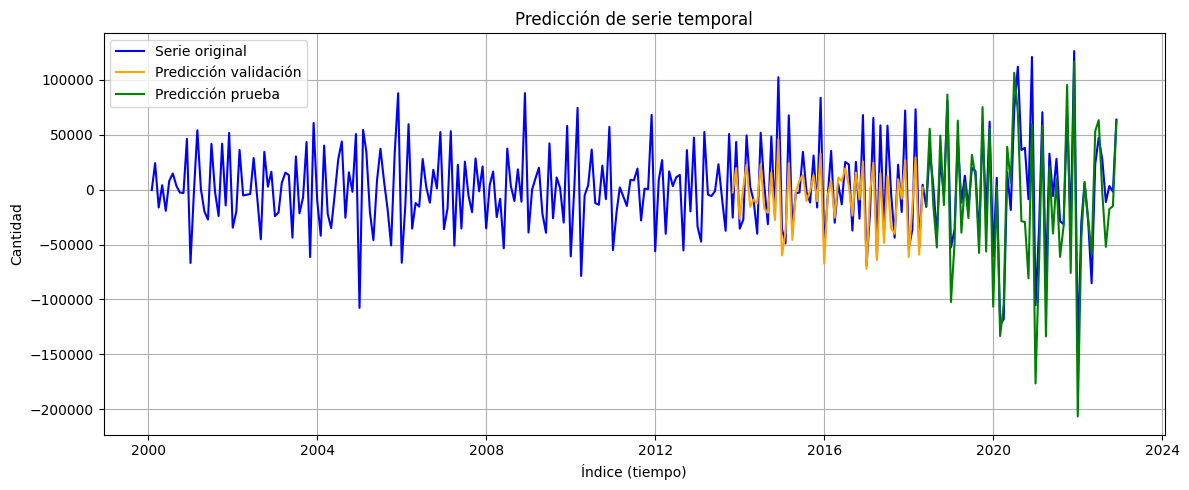

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(df[["Gasolina superior"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
